# Analysis of SAT Scores in New York City
This project began as part of DataQuest's cirriculum. Data from multiple sources were gathered together, cleaned, and combined into a single dataframe. Correlations between SAT scores and various factors such as class size, AP tests, demographics, and other variables were explored. Independently, I created a linear regression model with regularization that shows the most predictive variables for SAT scores in New York City. 

### Key Questions Explored
- What variables affect the SAT scores of students in New York City?

### Key Results
- The factors that most affect SAT scores seem to revolve around economics, opportunity, and race (though race results are correlated with economics and opportunity). For example schools that have higher percentages of free and reduced lunch students typically perform worse on the SAT's. 

### Techniques used
- pandas for data cleaning and manipulation
- Basemap for mapping
- matplotlib for data plotting
- scikitlearn for linear regression

# Reading in the data
There are multiple data files that will be compiled together, so each separate one will initially be read into a single dictionary.

In [173]:
import pandas
import numpy
import re
import matplotlib.pyplot as plt
%matplotlib inline

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv('{0}'.format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys
Additional surveys from students, parents, and teachers will be included as well.

In [174]:
all_survey = pandas.read_csv("survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey
data['survey'].head()

,DBN,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,...,eng_t_10,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11
0,01M015,NaN,88,60,NaN,22.0,90.0,8.5,7.6,7.5,...,NaN,7.9,NaN,NaN,NaN,NaN,8.0,7.7,7.5,7.9
1,01M019,NaN,100,60,NaN,34.0,161.0,8.4,7.6,7.6,...,NaN,9.1,NaN,NaN,NaN,NaN,8.5,8.1,8.2,8.4
2,01M020,NaN,88,73,NaN,42.0,367.0,8.9,8.3,8.3,...,NaN,7.5,NaN,NaN,NaN,NaN,8.2,7.3,7.5,8.0
3,01M034,89.0,73,50,145.0,29.0,151.0,8.8,8.2,8.0,...,NaN,7.8,6.2,5.9,6.5,7.4,7.3,6.7,7.1,7.9
4,01M063,NaN,100,60,NaN,23.0,90.0,8.7,7.9,8.1,...,NaN,8.1,NaN,NaN,NaN,NaN,8.5,7.6,7.9,8.0


# Add DBN columns
The common denominator between each dataset is the DBN, which is an identifying code for each school. In order to combine the datasets on a common variable, DBN will be formatted to be identical between datsets.

In [175]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric
In the SAT results dataset, the scores will be converted into numeric and combined into a single SAT score. Further, latitude and longitude strings that locate each school will be converted to numeric for later mapping.

In [176]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets
Some of the datasets have multiple rows for each school or DBN number, which would lead to multiple entries when combining the datasets. Thus, these datasets will be combined by selecting a single grade, single program type, and averaging the class sizes so that each school represents a single row.

In [177]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [178]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets
All of the separate datasets will be combined into a single dataset using the DBN values discussed earlier. The merging strategy will be dependent on how critical it is to retain information versus the number of null values the merge will create.

In [179]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping
Later, a map visualization will be created that requires a school district column.

In [180]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations
The first exploratory analysis of the data will look at the correlation between all the factors in the dataset and SAT scores. Only significant correlations (>0.25 or <-0.25 will be shown)

In [181]:
correlations = combined.corr()
correlations_sat = correlations["sat_score"]
print(correlations_sat)
correlations_sat_sign_high = correlations_sat[(correlations_sat > 0.25)]
correlations_sat_sign_low = correlations_sat[correlations_sat < -0.25]
correlations_sat_sign = pandas.concat([correlations_sat_sign_high, correlations_sat_sign_low])

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

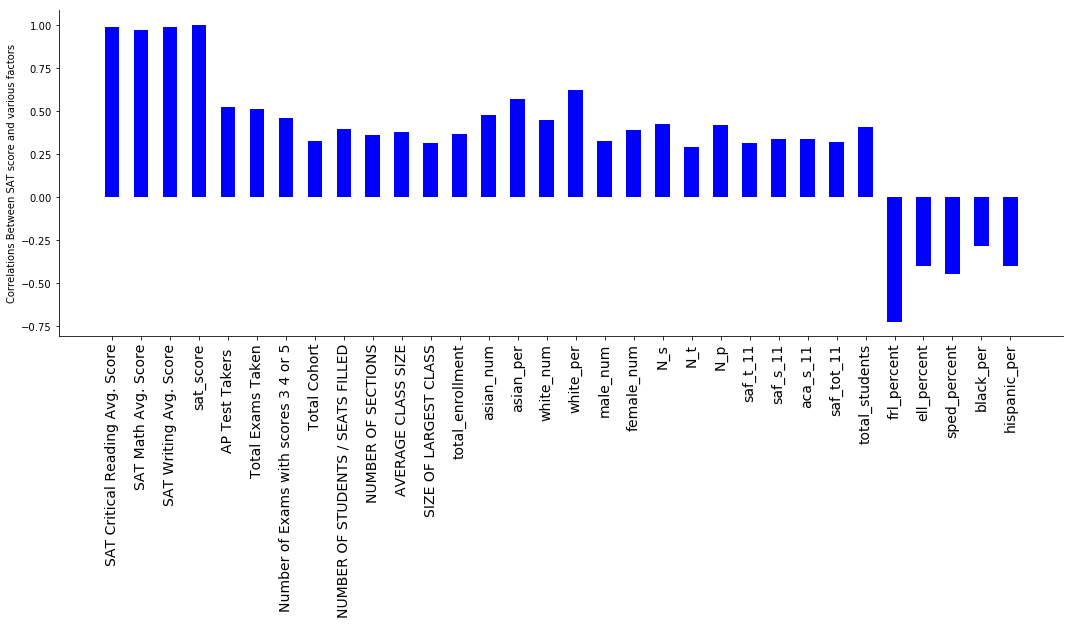

In [182]:
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(1,1,1)

to_plot = correlations_sat_sign

ax.bar(range(len(to_plot)), to_plot, 0.5,  color='blue',)

ax.set_xticks(range(len(to_plot)))
ax.set_xticklabels(correlations_sat_sign.index, rotation=90, fontsize=14)

plt.ylabel('Correlations Between SAT score and various factors')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

# Summary of initial correlations
A number of strong correlations appear. Obviously the individual test scores (math, writing, and reading) show very strong correlation. Other exams taken such as AP tests show strong positive correlation. Surprisingly, class size, number of sections, and largest class size correlate positively with SAT scores. A number of race factors have strong correlations and will be explored further later on. Finally, significant survey results will be explored next.

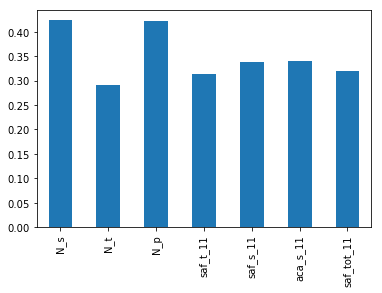

In [183]:
correlations_sat[survey_fields][correlations_sat[survey_fields] > 0.25].plot.bar()

## Correlation findings with teacher/parent/student surveys
The number of students, teachers, and parents (N_s, N_t, and N_p) who answers the survey positively correlated with SAT scores. This may be indicative of enthusiasm and or levels of involvement. The other main positive correlation in the survey was the "safety and respect" score for students and teachers (saf_t_11, saf_s_11, saf_tot_11). These results indicate that students who feel safe in their environment perform better on the SATs.

# Plotting the safety score of students with SAT scores

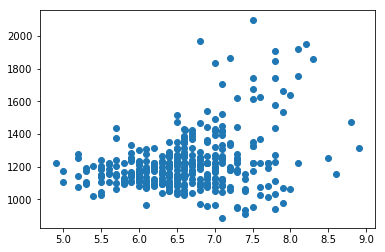

In [184]:
safety_students = combined['saf_s_11']
sat_score = combined['sat_score']

plt.scatter(safety_students, sat_score)

# Creating a map of school districts based on the average safety score
The map below will show which school districts students feel most safe in based on survey scores.

/Users/Mark/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/Mark/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/Mark/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


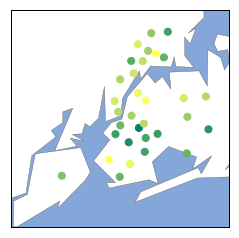

In [185]:
from mpl_toolkits.basemap import Basemap

district_mean = combined.groupby('school_dist').agg(numpy.mean)
safety_avg = district_mean['saf_s_11']
sat_dist_avg = district_mean['sat_score']
m = Basemap(
    projection='merc',
    llcrnrlat=40.496044,
    urcrnrlat=40.915256,
    llcrnrlon=-74.255735,
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

lats = district_mean['lat'].tolist()
lons = district_mean['lon'].tolist()

m.scatter(lons, lats, s=50, zorder=2, latlon=True, c=safety_avg, cmap='summer')
plt.show()

## Notes about safety location
It appears that Upper Manhattan, Queens, and the Bronx tend to have lower safety scores (lighter colors), while Brooklyn has high safety scores (darker greens).

# Exploring the correlations between race and SAT score

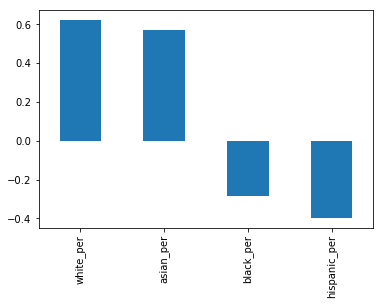

In [186]:
race = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
correlations_sat[race].plot.bar()

## Notes about race and SAT score
The SAT score correlates positively with the percentage of white and asian students, while it correlates negatively with the percentage of black and hispanic students. However, we will dig into the details further below.

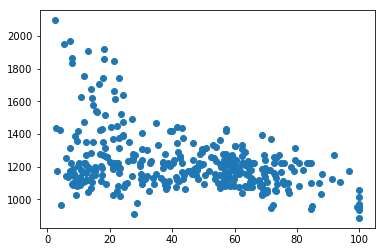

In [187]:
y=combined['sat_score']
x=combined['hispanic_per']
plt.scatter(x,y)
plt.show()

## Note about hispanic percentage and SAT score
Overall, there does not appear to be a strong correlation between SAT scores and hispanic student percentage. There are a few schools with low hispanic percents that score well and a few schools with very high hispanic percentage that score poorly, but otherwise no trend exists. I will look further into the very low and very high outliers in the following cells.

## Schools with high hispanic percentages

In [188]:
high_hispanic = combined[combined['hispanic_per'] > 95]
high_hispanic.loc[:,['SCHOOL NAME','hispanic_per']]

,SCHOOL NAME,hispanic_per
44,MANHATTAN BRIDGES HIGH SCHOOL,99.8
82,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,96.7
89,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,99.8
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY,99.4
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,99.8
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,99.8
253,MULTICULTURAL HIGH SCHOOL,99.8
286,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,100.0


After researching schools with high hispanic percents further, they are mostly schools for recent immigrants that are working to learn the English language. Their lack of experience with English would help explain some difficulties on the SAT scores.

## Schools with very low hispanic populations

In [189]:
low_hispanic = combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]
low_hispanic.loc[:,['SCHOOL NAME','hispanic_per']]

,SCHOOL NAME,hispanic_per
37,STUYVESANT HIGH SCHOOL,2.4
151,BRONX HIGH SCHOOL OF SCIENCE,7.2
187,BROOKLYN TECHNICAL HIGH SCHOOL,7.9
327,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,7.9
356,STATEN ISLAND TECHNICAL HIGH SCHOOL,5.3


These schools largely consist of specialized science and technology schools that admit students based on an entrance exam. This doesn't explain the low hispanic percentage, but it does help explain why their students perform better on the SAT.

# Correlations between gender and SAT scores

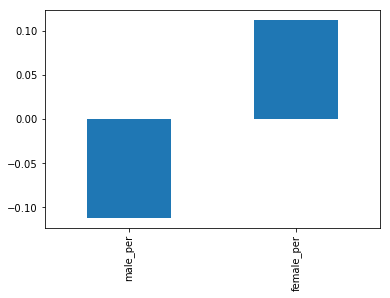

In [190]:
gender_fields = ["male_per", "female_per"]
combined.corr()["sat_score"][gender_fields].plot.bar()

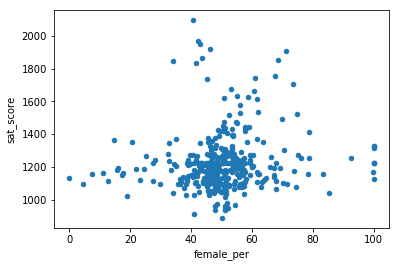

In [191]:
combined.plot.scatter("female_per", "sat_score")

Based on the scatterplot, there doesn't seem to be any real correlation between sat_score and female_per. However, there is a cluster of schools with a high percentage of females (60 to 80), and high SAT scores.


In [192]:
print(combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]["SCHOOL NAME"])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools appears to be very selective liberal arts schools that have high academic standards.

# Correlation between AP test takers and SAT scores

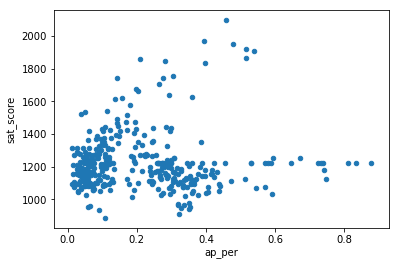

In [193]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]
combined.plot.scatter(x='ap_per', y='sat_score')

There appears to be a weak correlation between the SAT scores and the percentage of students who take AP tests.

# Creating a linear regression model
The following code will create a linear regression model to predict SAT scores based on the factors in the dataset. Due to the high number of explanatory variables, regularization will be used to revent over-fitting the model. 

In [194]:
X = combined.loc[:,correlations_sat_sign.index]
X = X.iloc[:,4:] # removing SAT scores from variables
X.head()

,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF LARGEST CLASS,total_enrollment,asian_num,...,saf_t_11,saf_s_11,aca_s_11,saf_tot_11,total_students,frl_percent,ell_percent,sped_percent,black_per,hispanic_per
0,129.028846,197.038462,153.45,78.0,88.000000,4.000000,22.564286,26.571429,422,59,...,6.3,6.000000,6.700000,6.7,323.0,88.6,22.3,24.9,29.1,53.8
1,39.000000,49.000000,10.00,124.0,105.687500,4.750000,22.231250,27.062500,394,115,...,6.6,6.000000,7.000000,6.8,299.0,71.8,21.1,21.8,22.6,45.9
2,19.000000,21.000000,153.45,90.0,57.600000,2.733333,21.200000,22.866667,598,58,...,7.3,6.611667,7.381389,7.9,649.0,71.8,5.0,26.4,23.9,55.4
3,129.028846,197.038462,153.45,84.0,69.642857,3.000000,23.571429,27.357143,367,34,...,6.4,6.400000,7.000000,6.9,401.0,80.7,11.2,25.9,31.6,56.9
4,255.000000,377.000000,191.00,46.0,156.368421,6.157895,25.510526,31.210526,1613,448,...,7.6,7.300000,7.700000,7.8,1725.0,23.0,0.2,2.7,11.7,14.2


In [195]:
Y = combined.loc[:,'sat_score']
Y.head()

0    1122.0
1    1172.0
2    1149.0
3    1207.0
4    1621.0
Name: sat_score, dtype: float64

In [196]:
### Running the model

In [197]:
from sklearn.linear_model import Ridge

X_norm = (X - X.min()) / (X.max() - X.min())

clf = Ridge(alpha=1) 
mdl = clf.fit(X_norm, Y)
m = mdl.coef_
b = mdl.intercept_
r_squared = mdl.score(X_norm, Y)
print('intercept: ', b)
print('R^2: ', r_squared)

intercept:  1414.29948902
R^2:  0.817999003953


Based on the intercept and R^2 value, the model appears to be performing reasonably well. The next cell will plot the various coefficients.

## Plotting regression coefficents

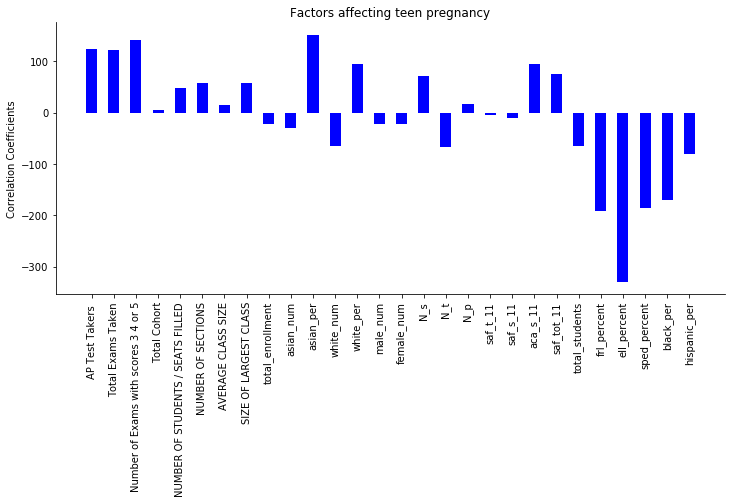

In [198]:
bar_position = range(8)

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,1,1)

ax.bar(range(len(m)), m, 0.5,  color='blue',)

ax.set_xticks(range(len(m)))
ax.set_xticklabels(X.columns, rotation = 90)


plt.ylabel('Correlation Coefficients')
plt.title('Factors affecting teen pregnancy')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

# Notes about trends in regression coefficents
A few different categories appear to have signficant effects on predicting SAT scores:
- Other exams taken such as AP tests increase SAT scores
- Percentage of white and asian students at the school increase SAT scores
- Students that report higher safety (saf_s/t_11) increase SAT scores
- Black and hispanic student percentages decrease SAT score (as observed earlier in correlations)
- Free and reduced lunched (frl_percent) and special education percent (sped_percent) reduce SAT scores

# Reducing number of variables
To reduced the number of explanatory variables, the results from above will be filtered to only include regression coefficients that change scores greater than 75 points in either direction.

In [199]:
coeff = pandas.DataFrame(m, index=X.columns)
high_coeff = coeff[coeff > 75]
low_coeff = coeff[coeff < -75]
sig_coeff = pandas.concat([low_coeff, high_coeff])
sig_coeff = sig_coeff.dropna()
len(sig_coeff.index)

12

In [200]:
X_new = combined.loc[:,sig_coeff.index]
X_new.head()

,frl_percent,ell_percent,sped_percent,black_per,hispanic_per,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,asian_per,white_per,aca_s_11,saf_tot_11
0,88.6,22.3,24.9,29.1,53.8,129.028846,197.038462,153.45,14.0,1.7,6.700000,6.7
1,71.8,21.1,21.8,22.6,45.9,39.000000,49.000000,10.00,29.2,2.3,7.000000,6.8
2,71.8,5.0,26.4,23.9,55.4,19.000000,21.000000,153.45,9.7,10.4,7.381389,7.9
3,80.7,11.2,25.9,31.6,56.9,129.028846,197.038462,153.45,9.3,1.6,7.000000,6.9
4,23.0,0.2,2.7,11.7,14.2,255.000000,377.000000,191.00,27.8,44.9,7.700000,7.8


# Re-running linear regression on model with few variables

In [201]:
from sklearn.linear_model import LinearRegression

X_norm = (X_new - X_new.min()) / (X_new.max() - X_new.min())

clf = Ridge(alpha=1) 
mdl = clf.fit(X_norm, Y)
m = mdl.coef_
b = mdl.intercept_
r_squared = mdl.score(X_norm, Y)
print(b)
print(m)
r_squared

1447.05031508
[-192.87696108 -338.10272541 -202.11999397 -159.77794361  -70.34612597
   98.76486386  104.54858356  156.16915863  143.02047301   79.55235021
   76.76077155   73.7504401 ]


0.80804672160668367

# Plotting coefficients from new model

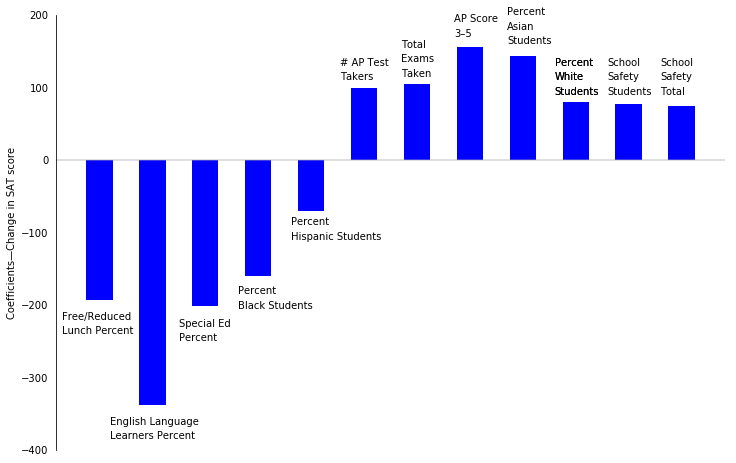

In [202]:
bar_position = range(8)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)

ax.bar(range(len(m)), m, 0.5,  color='blue',)

ax.set_ylim(-400, 200)
plt.ylabel('Coefficients—Change in SAT score')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(bottom="off", top="off", left="off", right="off", labelbottom='off')

ax.axhline(0, c=(171/255, 171/255, 171/255), alpha=0.5)

ax.text(-.7, -220, 'Free/Reduced'), ax.text(-.7, -240, 'Lunch Percent')
ax.text(.2, -365, 'English Language'), ax.text(.2, -385, 'Learners Percent')
ax.text(1.5, -230, 'Special Ed'), ax.text(1.5, -250, 'Percent')
ax.text(2.62, -185, 'Percent'), ax.text(2.62, -205, 'Black Students')
ax.text(3.62, -90, 'Percent'), ax.text(3.62, -110, 'Hispanic Students')
ax.text(4.55, 130, '# AP Test'), ax.text(4.55, 110, 'Takers')
ax.text(5.7, 155, 'Total'), ax.text(5.7, 135, 'Exams'), ax.text(5.7, 115, 'Taken')
ax.text(6.7, 190, 'AP Score'), ax.text(6.7, 170, '3–5')
ax.text(7.7, 200, 'Percent'), ax.text(7.7, 180, 'Asian'), ax.text(7.7, 160, 'Students')
ax.text(8.6, 130, 'Percent'), ax.text(8.6, 110, 'White'), ax.text(8.6, 90, 'Students')
ax.text(8.6, 130, 'Percent'), ax.text(8.6, 110, 'White'), ax.text(8.6, 90, 'Students')
ax.text(9.6, 130, 'School'), ax.text(9.6, 110, 'Safety'), ax.text(9.6, 90, 'Students')
ax.text(10.6, 130, 'School'), ax.text(10.6, 110, 'Safety'), ax.text(10.6, 90, 'Total')

fig.savefig("SAT scores.pdf")
plt.show()

# Summary of model results
The significant factors include economic, opportunity, and race categories. For example schools that have a high percentage of free lunch students or engligh language leaners have lower scores overall, while schools that have higher AP test taking percents perform better. The race coefficients match the correlations explored earlier that were partially skewed by outliers. Because of this, I will explore collinearity between race and some of the more dominant factors in this model.

# Correlation with race and free/reduced lunch percent

In [203]:
correlations_frl = correlations["frl_percent"][['white_per', 'black_per', 'hispanic_per', 'asian_per']]
correlations_frl

white_per      -0.722343
black_per       0.066348
hispanic_per    0.571657
asian_per      -0.383266
Name: frl_percent, dtype: float64

Hispanic students are much more likely to attend a school with a percentage of students receiving free or reduced lunches. White students in particular are much less likely to attend these schools

# Correlation with race and english language learners percent

In [204]:
correlations_frl = correlations["ell_percent"][['white_per', 'black_per', 'hispanic_per', 'asian_per']]
correlations_frl

white_per      -0.167932
black_per      -0.352072
hispanic_per    0.402839
asian_per       0.109514
Name: ell_percent, dtype: float64

Again, hispanic students are more likely to be part of a negative coefficient group in that they correlate more strong with english language learners. Students trying to learn the english language are more likely to struggle on the SAT.

# Correlation between race and safety surveys

In [205]:
correlations_frl = correlations["saf_s_11"][['white_per', 'black_per', 'hispanic_per', 'asian_per']]
correlations_frl

white_per       0.304034
black_per      -0.537179
hispanic_per    0.194651
asian_per       0.327836
Name: saf_s_11, dtype: float64

Safety surveys predict higher SAT scores. Here, black students are much less likely to report high safety at their schools, which could negatively affect their learning environments.

# Correlations between race and AP tests

In [206]:
correlations_frl = correlations["AP Test Takers "][['white_per', 'black_per', 'hispanic_per', 'asian_per']]
correlations_frl

white_per       0.304763
black_per      -0.226659
hispanic_per   -0.220731
asian_per       0.487636
Name: AP Test Takers , dtype: float64

White and Asian students are more likely to take AP tests that correlate positively with SAT scores. Whether this is due to the opportunity to take these courses and tests (they may not be offered at all schools) is unclear.

# Final Summary
While race has significant effects on the predicted SAT score, it is likely that these factors may be more related to other factors in the model such as economic situations, safety at the school, and opportunity for extracirricular learnings such as AP tests. Removing race from the model decreases the R^2 fit to 0.74 compared to a 0.80 with race, showing that these four factors have some impact on the response, but not a large one.